Benny Cohen

DAV 6150

Module 5 Assignment

In this notebook we are interested in creating functions to help evaluate machine learning models. 

We will create the functions then test them on a dataset containing the results of a model. 

I am not particularly interested in creating optimal functions since scikit learn is already more optimized. 

### Setup

Here we will import our test data. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
baseurl = 'https://raw.githubusercontent.com'
username = 'cohenb51'
branch = 'develop'
repo = 'Katz_School'
filePath = 'DAV6150/m5/M5_Data.csv'

df = pd.read_csv(f'{baseurl}/{username}/{repo}/{branch}/{filePath}')
df.head()

,pregnant,glucose,diastolic,skinfold,insulin,bmi,pedigree,age,class,scored.class,scored.probability
0,7,124,70,33,215,25.5,0.161,37,0,0,0.328452
1,2,122,76,27,200,35.9,0.483,26,0,0,0.273190
2,3,107,62,13,48,22.9,0.678,23,1,0,0.109660
3,1,91,64,24,0,29.2,0.192,21,0,0,0.055998
4,4,83,86,19,0,29.3,0.317,34,0,0,0.100491


In [3]:
df = df[['class', 'scored.class', 'scored.probability']]

In [4]:
df.head()

,class,scored.class,scored.probability
0,0,0,0.328452
1,0,0,0.273190
2,1,0,0.109660
3,0,0,0.055998
4,0,0,0.100491


This is a binary classifier. The class column can either be a 0 or a 1. The actual context doesn't per say matter for us since we are only interested in evaluating how our metric functions do. 

The class represents the true value. The scored.class represents the model's prediction. The scored.probability represents the probability that the class is a 1 with the model. 

In [5]:
df.shape

(181, 3)

We have 181 rows to work with. We will see in the next section the breakdown of predictions.

### How pd.crosstab works.

We will be using pandas's crosstab function to give us a frequency count. We can use this as our confusion matrix to calculate our statistics. 

In [6]:
crossTab = pd.crosstab(df['class'],df['scored.class'])
crossTab

scored.class,0,1
class,,
0,119,5
1,30,27


This tells us the 119 were correctly predicted negative, 27 correctly predicted postive, 5 incorrectly predicted positive, and 30 incorrectly predicted negative.

We could also check this with a group by. This really is the same thing just with a different index. 

In [7]:
#check 
df.groupby(['class', 'scored.class']).count()

scored.probability
class scored.class                    
0     0                            119
      1                              5
1     0                             30
      1                             27

We see the same results here. I think this is slightly easier to look at since we could read accross.

### Edge Cases

Since pd.crosstab is a frequency count it would not preform correctly where there are no entries for a given value. (ex. all were predicted negative)

In [8]:
testDf = df.iloc[1:2]
testDf.head()

,class,scored.class,scored.probability
1,0,0,0.27319


Let's say we have 1 negative prediction...

In [9]:
crossTab = pd.crosstab(testDf['class'],testDf['scored.class'])
crossTab

scored.class,0
class,
0,1


If we are going to index the pd.crosstab to create our statistics we need a way to guarantee that the crosstab will be a 2x2 matrix. (since we are doing a binary classifier). One way we can do this is by just arbitrarily adding 1 of each type of prediction. We will do this in our code below.

### Creating the functions.

In [10]:
# Wrapper class for readability purposes.
class ConfusionMatrix():
    def __init__(self,actual, predicted):
        self.validate(actual,predicted)
        actual_c = list(actual)      
        predicted_c = list(predicted)
        
        # Append fake values to assure us a 2x2 matrix.
        actual_c.append(0)
        predicted_c.append(0)
        
        actual_c.append(1)
        predicted_c.append(0)
        
        actual_c.append(0)
        predicted_c.append(1)
        
        actual_c.append(1)
        predicted_c.append(1)
        
        dc = pd.Series(actual_c)
        dc2 = pd.Series(predicted_c)
     
        self.crossTab = pd.crosstab(dc,dc2)
        if self.crossTab.shape != (2,2):
            raise Exception("This class only works for binary classifiers.")
        self.Size = len(actual)
        
    def validate(self, actual, predicted):
        if len(actual) != len(predicted):
            raise Exception("The length of the predictions do not match the length of the actual values")
            
    def TruePositives(self):
        return self.crossTab[1][1] -1
    
    def TrueNegatives(self):
        return self.crossTab[0][0] -1
    
    def FalsePositives(self):
        return self.crossTab[1][0] -1
    
    def FalseNegatives(self):
        return self.crossTab[0][1] -1
    
    def ConfusionMatrix(self):
        clone = self.crossTab.copy()
        clone[0][0] = self.crossTab[0][0] -1
        clone[0][1] = self.crossTab[0][1] - 1
        clone[1][0] = self.crossTab[1][0] -1
        clone[1][1] = self.crossTab[1][1] -1
        return clone

            

<hr>

I'm not really sure how to make the self.crosstab a private variable because really it shouldn't be accessed directly. It will clearly give the wrong confusion matrix as I am increasing the value of each row and column by one. I also don't want people to be able to edit the value.

#### Accuracy

This gives us ratio of correctly predicted values.

In [11]:
def GetAccuracy(actual, predicted):
    confusionMatrix = ConfusionMatrix(actual, predicted)
    return (confusionMatrix.TruePositives() + confusionMatrix.TrueNegatives()) / confusionMatrix.Size

#### Precision

This gives us the ratio of correct positive predictions.

In [12]:
def GetPrecision(actual, predicted):
    confusionMatrix = ConfusionMatrix(actual, predicted)
    return confusionMatrix.TruePositives() /  (confusionMatrix.TruePositives() + confusionMatrix.FalsePositives())

#### Sensitivity 

This gives us the ratio of actual positives that were predicted correctly.

In [13]:
def GetSensitivity(actual, predicted):
    confusionMatrix = ConfusionMatrix(actual, predicted)
    return confusionMatrix.TruePositives()/ (confusionMatrix.TruePositives() + confusionMatrix.FalseNegatives())

#### Specifity

This gives us the ratio of actual negatives which were predicted correctly.

In [14]:
def GetSpecifity(actual, predicted):
    confusionMatrix = ConfusionMatrix(actual, predicted)
    return confusionMatrix.TrueNegatives() / (confusionMatrix.TrueNegatives() + confusionMatrix.FalsePositives())

#### F1 Score

This is a function of recall (sensitivity) and precision. The single number it outputs is a useful metric to compare both recall and precision between models.

In [15]:
def GetF1Score(actual, predicted):
    precision = GetPrecision(actual,predicted) # I guess we could optimize this to use 1 confusion matrix. 
    recall = GetSensitivity(actual,predicted)
    return 2 * (precision * recall)/(precision+recall)

### Roc and Auc Curve
The roc curve plots 1-specifity on the x axis and the sensitivity on the y axis. Naturally, The more area under the graph the better the model. A random graph would be along the line x = y since half the guesses would be correct and half wrong. 

In [16]:
def Plot(x,y):
    plt.plot(x,y)
def GetRegularCutoffs():
    return np.arange(0,1, .005)

In [17]:
# Cutoffs is an array of what points to evaluate at. The more elements, the longer it will take to complete. 
# I do not do any validations on this since it is just for me to use. It is slow because the Get Specifity and Sensitivity are really slow.
#There probably is a way to cache results. 

#Note: Cutoffs must be ordered from low to high for auc calculation to work properly. 
def GetRocPlot(actual, predicted, probs, cutoffs = None):
    if cutoffs == None:
        cutoffs = GetRegularCutoffs()
    y = []
    x = []
    for cutoff in cutoffs:
        tPred = probs.map(lambda x: 0 if x < cutoff else 1)
        x.append(1 - GetSpecifity(actual, tPred))
        y.append(GetSensitivity(actual, tPred))
    Plot(x, y)
    return (x, y, GetAuc(x,y))

All I'm doing in the function above is evaluating the specifity at each cutoff point and then plotting them.

Auc gives the area under the roc curve. The closer to 1 the better. 

In [18]:
def GetAuc(x,y):
    sum = 0
    xStart = x[0]
    for i in range(1, len(x)): 
        dy = y[i-1] - y[i] 
        if(dy >0):
            dx = (xStart - x[i])
            dy = y[i -1]
            if y[i] == 0:
                triangle = (dx * dy)/2
                sum = sum + triangle
                break
            sum = sum + dx * dy
            xStart = x[i]
    return sum

In this function I am just creating rectangles and adding the area of each one untill the last one which makes a triangle.

### Evaluation

In this section we are just going to get the outputs of using the functions on our dataset.

In [19]:
GetAccuracy(df['class'],df['scored.class'])

0.8066298342541437

In [20]:
GetPrecision(df['class'],df['scored.class'])

0.84375

In [21]:
GetSensitivity(df['class'],df['scored.class'])

0.47368421052631576

In [22]:
GetSpecifity(df['class'],df['scored.class'])

0.9596774193548387

In [23]:
GetF1Score(df['class'],df['scored.class'])

0.6067415730337079

Now let's compare with scikit learn functions.

In [24]:
import sklearn.metrics as metrics

print(f"Accuracy: scikit-learn: {metrics.accuracy_score(df['class'],df['scored.class'])} Mine: {GetAccuracy(df['class'],df['scored.class'])}")
print(f"Precision: scikit-learn: {metrics.precision_score(df['class'],df['scored.class'])} Mine: {GetPrecision(df['class'],df['scored.class'])}")
print(f"Recall: scikit-learn: {metrics.recall_score(df['class'],df['scored.class'])} Mine: {GetSensitivity(df['class'],df['scored.class'])}")
print(f"f1Score: scikit-learn: {metrics.f1_score(df['class'],df['scored.class'])} Mine: {GetF1Score(df['class'],df['scored.class'])}")

Accuracy: scikit-learn: 0.8066298342541437 Mine: 0.8066298342541437
Precision: scikit-learn: 0.84375 Mine: 0.84375
Recall: scikit-learn: 0.47368421052631576 Mine: 0.47368421052631576
f1Score: scikit-learn: 0.6067415730337079 Mine: 0.6067415730337079


Confusion Matrix compare

In [25]:
metrics.confusion_matrix(df['class'],df['scored.class'])

array([[119,   5],
       [ 30,  27]], dtype=int64)

In [26]:
ConfusionMatrix(df['class'],df['scored.class']).ConfusionMatrix()

col_0,0,1
row_0,,
0,119,5
1,30,27


Our confusion matrix is functionally the same. 

In [27]:
metrics.classification_report(df['class'],df['scored.class'])

'              precision    recall  f1-score   support\n\n           0       0.80      0.96      0.87       124\n           1       0.84      0.47      0.61        57\n\n    accuracy                           0.81       181\n   macro avg       0.82      0.72      0.74       181\nweighted avg       0.81      0.81      0.79       181\n'

These are the same scores as above just rounded. 

Now let's compare our roc curve. First ours...

0.8525042444821731

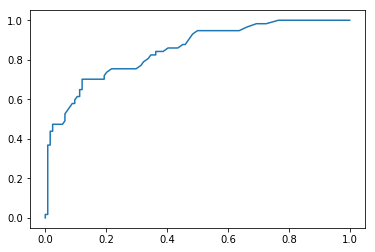

In [28]:
_,_, auc = GetRocPlot(df['class'],df['scored.class'], df['scored.probability'])
auc

Now theirs...

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(df['class'],df['scored.probability'])


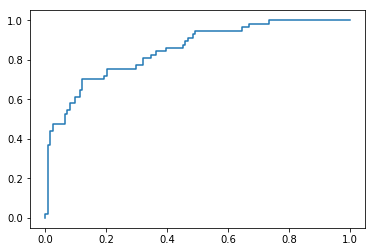

In [30]:
plt.plot(fpr,tpr)

These graphs look very similar. 

In [31]:
print(f"AUC: scikit-learn: {metrics.auc(fpr, tpr)} Mine: {auc}")


AUC: scikit-learn: 0.8503112620260327 Mine: 0.8525042444821731


Our auc's are about the same (to the hundreths place at least). Scikit Learn is much faster. 

In [32]:
len(thresholds)

51

Scikit-learn only evaluated the graph at 51 points. I'm not really sure where that 51 came from. My function lets you provide where to evaluate the function by providing a list but by default I call the below function.

In [33]:
GetRegularCutoffs().shape[0] 

200

Above is how many points I evaluate the function at. 

We could see how our function does with the thresholds that Scikit learn has.

In [34]:
fpr = list(fpr)
tpr = list(tpr)

fpr.reverse()
tpr.reverse()
auc = GetAuc(fpr,tpr)

In [35]:
print(f"AUC: scikit-learn: {metrics.auc(fpr, tpr)} Mine: {auc}")

AUC: scikit-learn: 0.8503112620260327 Mine: 0.8502405206564797


This is kind of interesting. With less thresholds my auc is closer to scikit learn's value. I'm tempted to say that my version might be more accurate just a lot slower since I am evaluating it at a lot more points. Let's see the graph. 

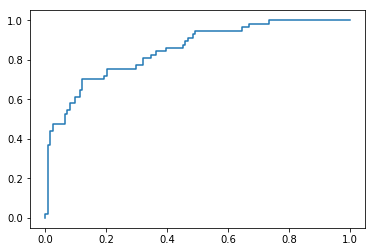

In [36]:
_, _, _ = GetRocPlot(df['class'],df['scored.class'],df['scored.probability'], list(thresholds))

We have the same graph as scikit learn. Compared to our original, the graph has a lot more steps and isn't as smooth. 

Let's look at performance.

In [ ]:
%%timeit 
# evaluating with scikit learn's choice of points.
_, _, _ = GetRocPlot(df['class'],df['scored.class'],df['scored.probability'], list(thresholds))

7.02 s ± 249 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


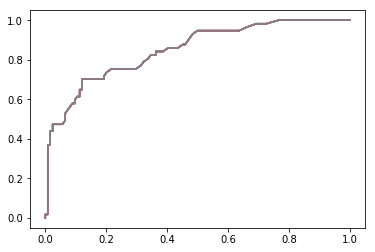

In [38]:
%%timeit
_, _, _ = GetRocPlot(df['class'],df['scored.class'],df['scored.probability'])

There is a big jump. When we evaluate it at 51 points it takes 1.5 seconds but when we evaluate it at 200 points it takes 7 seconds. 

This is experimentally ~ O(n) but n here is a parameter. This really doesn't need to be if we think this through more. Also, even in the first case over a second is really really bad considering we only have around 180 points- our functions are basically not even usable.

Compared to scikit learn...

3.87 ms ± 751 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


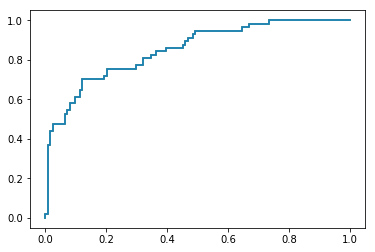

In [39]:
%%timeit
x,y,c = metrics.roc_curve(df['class'],df['scored.probability'])
plt.plot(x,y)


There really isn't a comparison to make in terms of performance here theirs is so much better.